In [1]:
import numpy as np
import random
import seaborn as sns
import contextily as cx
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import os
import re
import csv
import json


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot


import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
BEI_variables_cleaned = gpd.read_file('BEI_Cleaned_Aug15.shp')

In [3]:
BEI_variables_cleaned.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

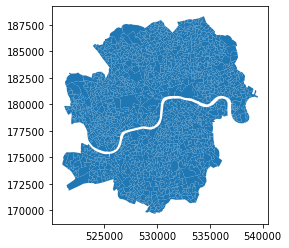

In [4]:
BEI_variables_cleaned.plot()

### Standardizing and cleaning demographic data

In [5]:
BEI_variables_cleaned['Youth(<18)_norm'] = BEI_variables_cleaned['Youth(<18)']/BEI_variables_cleaned['Area(m^2)']
BEI_variables_cleaned['Elderly(>6_norm'] = BEI_variables_cleaned['Elderly(>6']/BEI_variables_cleaned['Area(m^2)']
BEI_variables_cleaned['No_car_hou_norm'] = BEI_variables_cleaned['No_car_hou']/BEI_variables_cleaned['Area(m^2)']
BEI_variables_cleaned['Minority_p_norm'] = BEI_variables_cleaned['Minority_p']/BEI_variables_cleaned['Area(m^2)']
BEI_variables_cleaned['Unemployed_norm'] = BEI_variables_cleaned['Unemployed']/BEI_variables_cleaned['Area(m^2)']

In [6]:
BEI_variables_cleaned

LSOA11CD             LSOA11NM  Youth(<18)  Elderly(>6  No_car_hou  \
0     E01000001  City of London 001A       122.0       268.0       519.0   
1     E01000002  City of London 001B       154.0       269.0       481.0   
2     E01000003  City of London 001C       137.0       254.0       655.0   
3     E01000005  City of London 001E       182.0       127.0       356.0   
4     E01000842          Camden 011A       205.0       201.0       353.0   
...         ...                  ...         ...         ...         ...   
1412  E01033709         Hackney 027H       270.0        76.0       629.0   
1413  E01033710         Hackney 028E       308.0        30.0       359.0   
1414  E01033711         Hackney 027I        91.0        37.0       388.0   
1415  E01033712         Hackney 023G       319.0        53.0       441.0   
1416  E01033713         Hackney 010G       274.0        68.0       429.0   

      Minority_p  Unemployed  Area(m^2)      Borough_na  \
0          228.0        97.0     133370  City of London   
1          162.0        82.0     226274  City of London   
2          291.0       231.0      57324  City of London   
3          480.0       274.0     190808  City of London   
4          275.0       170.0     103740          Camden   
...          ...         ...        ...             ...   
1412       741.0       392.0      87009         Hackney   
1413       579.0       281.0      41406         Hackney   
1414       401.0       335.0      77928         Hackney   
1415       627.0       407.0     162825         Hackney   
1416       636.0       396.0     261553         Hackney   

                                               geometry  Youth(<18)_norm  \
0     POLYGON ((532105.092 182011.230, 532162.491 18...         0.000915   
1     POLYGON ((532746.813 181786.891, 532671.688 18...         0.000681   
2     POLYGON ((532135.145 182198.119, 532158.250 18...         0.002390   
3     POLYGON ((533807.946 180767.770, 533649.063 18...         0.000954   
4     POLYGON ((527317.841 184750.587, 527357.075 18...         0.001976   
...                                                 ...              ...   
1412  POLYGON ((532726.570 183211.594, 532719.197 18...         0.003103   
1413  POLYGON ((535485.625 186863.250, 535487.798 18...         0.007439   
1414  POLYGON ((533056.000 182962.000, 533055.000 18...         0.001168   
1415  POLYGON ((534776.000 183995.000, 534809.638 18...         0.001959   
1416  POLYGON ((534918.108 185913.311, 534885.850 18...         0.001048   

      Elderly(>6_norm  No_car_hou_norm  Minority_p_norm  Unemployed_norm  
0            0.002009         0.003891         0.001710         0.000727  
1            0.001189         0.002126         0.000716         0.000362  
2            0.004431         0.011426         0.005076         0.004030  
3            0.000666         0.001866         0.002516         0.001436  
4            0.001938         0.003403         0.002651         0.001639  
...               ...              ...              ...              ...  
1412         0.000873         0.007229         0.008516         0.004505  
1413         0.000725         0.008670         0.013983         0.006786  
1414         0.000475         0.004979         0.005146         0.004299  
1415         0.000326         0.002708         0.003851         0.002500  
1416         0.000260         0.001640         0.002432         0.001514  

[1417 rows x 15 columns]

In [7]:
print(BEI_variables_cleaned.columns.tolist())


['LSOA11CD', 'LSOA11NM', 'Youth(<18)', 'Elderly(>6', 'No_car_hou', 'Minority_p', 'Unemployed', 'Area(m^2)', 'Borough_na', 'geometry', 'Youth(<18)_norm', 'Elderly(>6_norm', 'No_car_hou_norm', 'Minority_p_norm', 'Unemployed_norm']


In [8]:
BEI_variables_final = BEI_variables_cleaned

In [9]:
to_drop = ['Youth(<18)', 'Elderly(>6', 'No_car_hou', 'Minority_p', 'Unemployed', 'Area(m^2)']
BEI_variables_final = BEI_variables_final.drop(columns=to_drop)
BEI_variables_final.head(2)

LSOA11CD             LSOA11NM      Borough_na  \
0  E01000001  City of London 001A  City of London   
1  E01000002  City of London 001B  City of London   

                                            geometry  Youth(<18)_norm  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...         0.000915   
1  POLYGON ((532746.813 181786.891, 532671.688 18...         0.000681   

   Elderly(>6_norm  No_car_hou_norm  Minority_p_norm  Unemployed_norm  
0         0.002009         0.003891         0.001710         0.000727  
1         0.001189         0.002126         0.000716         0.000362

In [10]:
import numpy as np
from scipy import stats

In [11]:
print ("\nZ-score for arr1 : \n", stats.zscore(BEI_variables_final['Youth(<18)_norm']))


Z-score for arr1 : 
 0      -1.101125
1      -1.234276
2      -0.262287
3      -1.078897
4      -0.497605
          ...   
1412    0.143267
1413    2.608539
1414   -0.957262
1415   -0.507236
1416   -1.025587
Name: Youth(<18)_norm, Length: 1417, dtype: float64


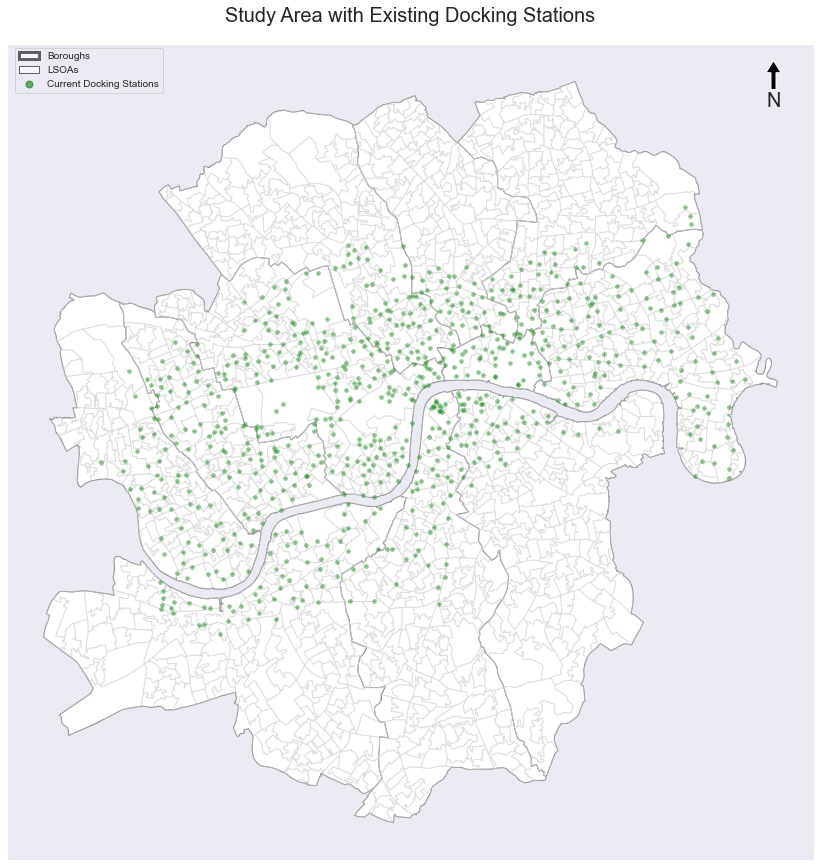

In [569]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


boros.plot(ax=ax,facecolor="white",edgecolor='grey',alpha=1).set_title(
    "Study Area with Existing Docking Stations", y=1.02, size=20
);
BEI_variables_cleaned.plot(ax=ax, facecolor="none", edgecolor="lightgrey", alpha=0.5)

trip_7domain.plot(ax=ax, marker="*", color="green",linewidth=2.7, markersize=5, alpha=0.4)






white_patch = mpatches.Patch(linewidth=3,edgecolor='black',facecolor='#ffffff',alpha=0.6, label='Boroughs')
white_lsoa_patch = mpatches.Patch(linewidth=1,edgecolor='black',facecolor='#ffffff',alpha=0.6, label='LSOAs')

green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Current Docking Stations')


plt.legend(handles=[white_patch,white_lsoa_patch,green_dot],loc=[0.01,0.94], prop={'size': 10})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig("figures/map_1_study_area", dpi=500)

### Calculating z-score

In [12]:
BEI_variables_final['z_score_youth'] = stats.zscore(BEI_variables_final['Youth(<18)_norm'])
BEI_variables_final['z_score_elderly'] = stats.zscore(BEI_variables_final['Elderly(>6_norm'])
BEI_variables_final['z_score_nocar'] = stats.zscore(BEI_variables_final['No_car_hou_norm'])
BEI_variables_final['z_score_Minor'] = stats.zscore(BEI_variables_final['Minority_p_norm'])
BEI_variables_final['z_score_unemployed'] = stats.zscore(BEI_variables_final['Unemployed_norm'])

In [13]:
BEI_variables_ind = BEI_variables_final

### Calculating Bike Equity Index (BEI)
BEI_i = E_i + Y_i + C_i + M_i + L_i
* Negative values are changed to 0 for eliminate negative influence

In [14]:
BEI_variables_ind['z_score_youth_zero'] = [0 if i < 0 else i for i in BEI_variables_ind['z_score_youth']]
BEI_variables_ind['z_score_elderly_zero'] = [0 if i < 0 else i for i in BEI_variables_ind['z_score_elderly']]
BEI_variables_ind['z_score_nocar_zero'] = [0 if i < 0 else i for i in BEI_variables_ind['z_score_nocar']]
BEI_variables_ind['z_score_Minor_zero'] = [0 if i < 0 else i for i in BEI_variables_ind['z_score_Minor']]
BEI_variables_ind['z_score_unemployed_zero'] = [0 if i < 0 else i for i in BEI_variables_ind['z_score_unemployed']]

In [15]:
BEI_variables_ind['BEI_ind'] = BEI_variables_ind['z_score_youth_zero'] + BEI_variables_ind['z_score_elderly_zero'] + BEI_variables_ind['z_score_nocar_zero'] + BEI_variables_ind['z_score_Minor_zero'] + BEI_variables_ind['z_score_unemployed_zero']

In [16]:
import statistics
one_std = statistics.stdev(BEI_variables_ind['BEI_ind'])
one_std

3.0971127754433745

#### Result of BEI shown in a histogram


In [17]:
BEI_variables_ind.max()

LSOA11CD                          E01033713
LSOA11NM                   Westminster 024F
Borough_na                      Westminster
Youth(<18)_norm                    0.018629
Elderly(>6_norm                    0.009758
No_car_hou_norm                    0.022871
Minority_p_norm                    0.040156
Unemployed_norm                    0.025016
z_score_youth                      8.971921
z_score_elderly                   10.842745
z_score_nocar                      7.783314
z_score_Minor                      7.954072
z_score_unemployed                  8.51072
z_score_youth_zero                 8.971921
z_score_elderly_zero              10.842745
z_score_nocar_zero                 7.783314
z_score_Minor_zero                 7.954072
z_score_unemployed_zero             8.51072
BEI_ind                           43.412809
dtype: object

In [580]:
BEI_variables_ind['BEI_ind'].mean()

1.8121281464707224

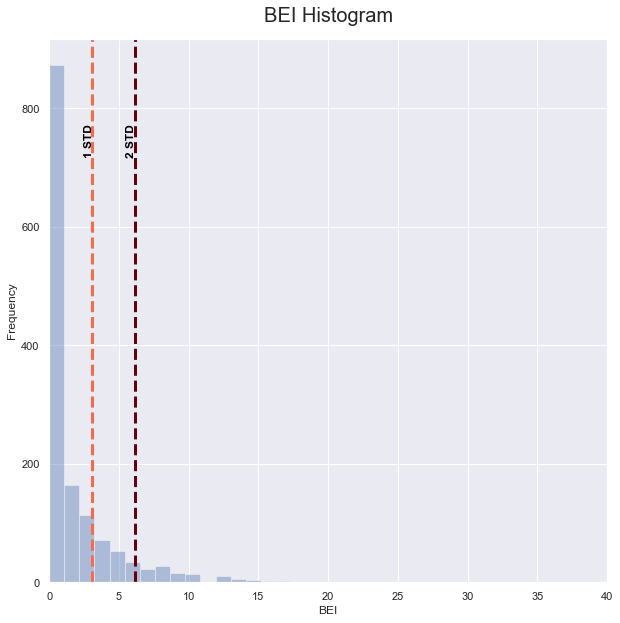

In [483]:
fig, ax = plt.subplots(figsize=(10, 10))



sns.distplot(BEI_variables_ind['BEI_ind'], bins = 40,color='b', kde=False).set_title(
    "BEI Histogram", y=1.02, size=20
);

plt.xlabel('BEI')
ax.set_xlim([0, 40])
plt.ylabel('Frequency')


plt.axvline(
    np.std(BEI_variables_ind.BEI_ind), color="#fb694a", linestyle="dashed", linewidth=3)

plt.axvline(
    np.std(BEI_variables_ind.BEI_ind)*2, color="#67000d", linestyle="dashed", linewidth=3)

plt.text(2.5, 720, "1 STD", horizontalalignment='left', size='medium', color='black', weight='semibold',rotation=90)
plt.text(5.5, 720, "2 STD", horizontalalignment='left', size='medium', color='black', weight='semibold',rotation=90)

fig.savefig("figures/fig_3_BEI_hist", dpi=500)

### Mapping the BEI result

In [19]:
#Current docks file
trip_7domain = gpd.read_file('trip_with_factors_good.shp')

In [20]:
trip_7domain = trip_7domain.to_crs("epsg:27700")


In [21]:
BEI_variables_ind['BEI_ind_zs'] = stats.zscore(BEI_variables_final['BEI_ind'])

In [22]:
min_zs = BEI_variables_ind['BEI_ind_zs'].min()

In [23]:
min_zs

-0.5853089766925277

<AxesSubplot:xlabel='BEI_ind_zs', ylabel='Density'>

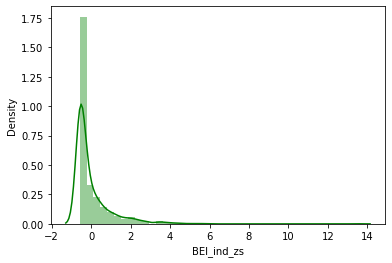

In [24]:
sns.distplot(BEI_variables_ind['BEI_ind_zs'], bins = 40,color='green')



In [25]:
BEI_variables_ind['BEI_ind_zs']

0      -0.278209
1      -0.585309
2       1.775032
3      -0.585309
4      -0.307861
          ...   
1412    0.209544
1413    1.900445
1414   -0.352280
1415   -0.585309
1416   -0.585309
Name: BEI_ind_zs, Length: 1417, dtype: float64

In [26]:
BEI_variables_ind['BEI_ind_zs'].count()

1417

In [27]:
BEI_variables_ind['BEI_ind_zs'][(BEI_variables_ind['BEI_ind_zs'] <= min_zs+1)].count()

1141

In [28]:
BEI_variables_ind['BEI_ind_zs'][(BEI_variables_ind['BEI_ind_zs'] > min_zs+1) & (BEI_variables_ind['BEI_ind_zs'] <= min_zs+2)].count()

157

In [29]:
BEI_variables_ind['BEI_ind_zs'][(BEI_variables_ind['BEI_ind_zs'] > min_zs+2)].count()

119

In [47]:
#Use this variable to summarize statistics
BEI_variables_ind_boro = BEI_variables_ind



In [48]:
aa = BEI_variables_ind_boro[(BEI_variables_ind_boro['BEI_ind_zs'] <= min_zs+1)]

In [49]:
bb = BEI_variables_ind_boro[(BEI_variables_ind_boro['BEI_ind_zs'] > min_zs+1) & (BEI_variables_ind_boro['BEI_ind_zs'] <= min_zs+2)]

In [50]:
cc = BEI_variables_ind_boro[(BEI_variables_ind_boro['BEI_ind_zs'] > min_zs+2)]

In [53]:
aaa = aa.groupby('Borough_na')

In [63]:
aaa.Borough_na.count()

Borough_na
Camden                    104
City of London              5
Hackney                   117
Hammersmith and Fulham     95
Islington                 107
Kensington and Chelsea     78
Lambeth                   163
Southwark                 134
Tower Hamlets              85
Wandsworth                174
Westminster                79
Name: Borough_na, dtype: int64

In [64]:
bbb = bb.groupby('Borough_na')
bbb.Borough_na.count()

Borough_na
Camden                    15
Hackney                   14
Hammersmith and Fulham    10
Islington                 11
Kensington and Chelsea    18
Lambeth                    8
Southwark                 23
Tower Hamlets             37
Wandsworth                 3
Westminster               18
Name: Borough_na, dtype: int64

In [65]:
ccc = cc.groupby('Borough_na')
ccc.Borough_na.count()

Borough_na
Camden                    14
City of London             1
Hackney                   13
Hammersmith and Fulham     8
Islington                  5
Kensington and Chelsea     7
Lambeth                    7
Southwark                  9
Tower Hamlets             22
Wandsworth                 2
Westminster               31
Name: Borough_na, dtype: int64

In [59]:
#pip install matplotlib-scalebar


In [60]:
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances

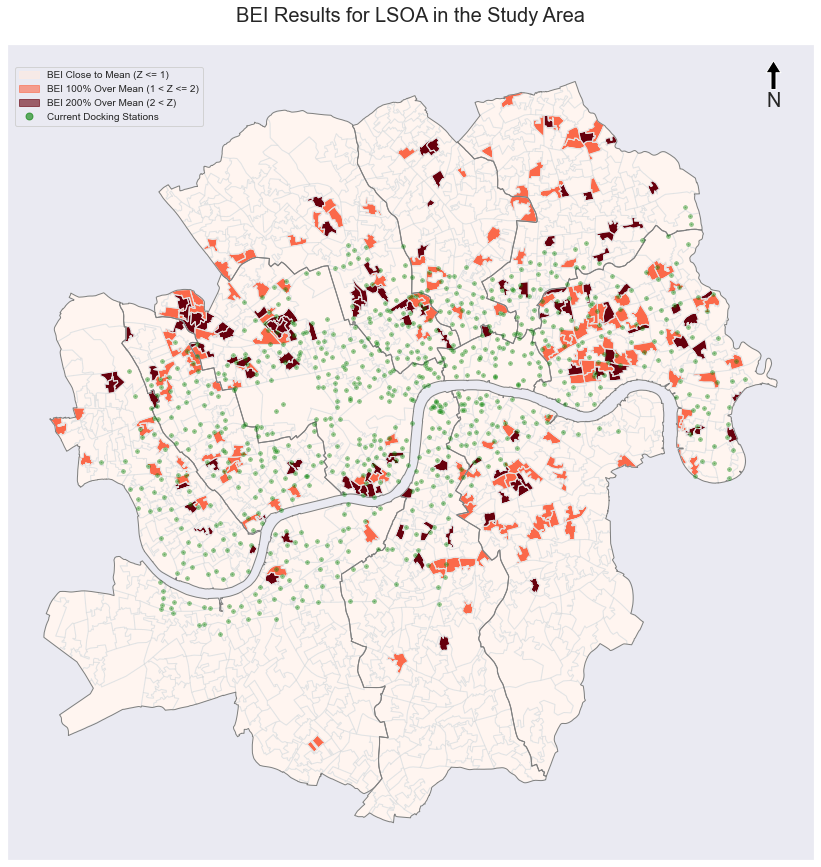

In [573]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


BEI_variables_ind.plot(ax=ax, column='BEI_ind_zs', legend=True, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds").set_title(
    "BEI Results for LSOA in the Study Area", y=1.02, size=20
);
#'boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'stdmean', 'userdefined'
#BEI_variables_ind.plot(ax=ax, column='BEI_ind', legend=True, figsize=(8,8),scheme='jenkscaspallsampled', cmap="Reds");
#ax.axis("off")

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.4)
boros.plot(ax=ax,facecolor="None",edgecolor='grey')

trip_7domain.plot(ax=ax, marker="*", color="green",linewidth=2.7, markersize=5, alpha=0.4)






lv1_patch = mpatches.Patch(color='#ffebe1',alpha=0.6, label='BEI Close to Mean (Z <= 1)')
lv2_patch = mpatches.Patch(color='#fb694a',alpha=0.6, label='BEI 100% Over Mean (1 < Z <= 2)')
lv3_patch = mpatches.Patch(color='#67000d',alpha=0.6, label='BEI 200% Over Mean (2 < Z)')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Current Docking Stations')


plt.legend(handles=[lv1_patch,lv2_patch,lv3_patch,green_dot],loc=[0.01,0.9], prop={'size': 10})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig("figures/map_3_BEI", dpi=500)

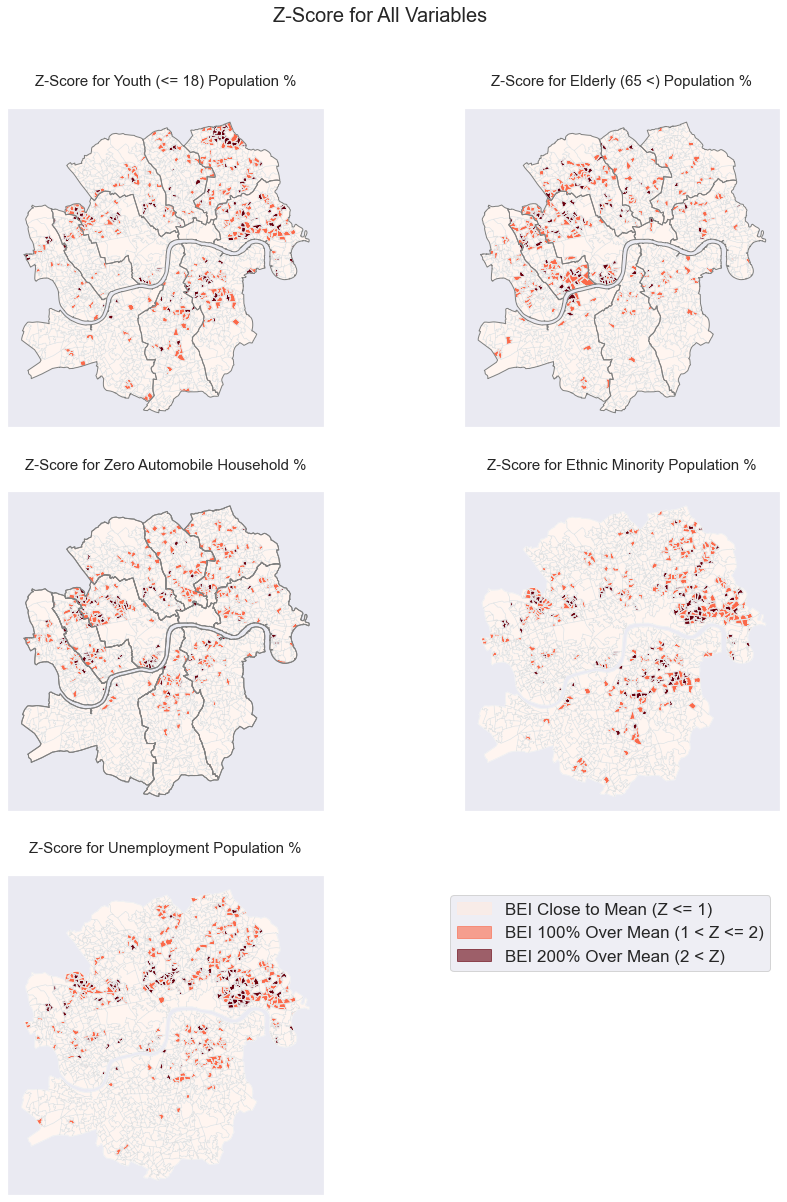

In [570]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(3,2,figsize=(15,20))
axes[2, 1].remove()

fig.suptitle('Z-Score for All Variables', y=0.95, size=20)

BEI_variables_ind.plot(ax=axes[0,0], column='z_score_youth_zero', legend=False, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds");
BEI_variables_ind.plot(ax=axes[0,1], column='z_score_elderly_zero', legend=False, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds");
BEI_variables_ind.plot(ax=axes[1,0], column='z_score_nocar_zero', legend=False, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds");
BEI_variables_ind.plot(ax=axes[1,1], column='z_score_Minor_zero', legend=False, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds");
BEI_variables_ind.plot(ax=axes[2,0], column='z_score_unemployed_zero', legend=False, figsize=(8,8),scheme='user_defined', classification_kwds={'bins':[min_zs+1,min_zs+2]}, cmap="Reds");

BEI_variables_cleaned.plot(ax=axes[0,0], facecolor="None", edgecolor="lightgrey", linewidth = 0.7, alpha=0.4)
BEI_variables_cleaned.plot(ax=axes[0,1], facecolor="None", edgecolor="lightgrey", linewidth = 0.7,alpha=0.4)
BEI_variables_cleaned.plot(ax=axes[1,0], facecolor="None", edgecolor="lightgrey", linewidth = 0.7,alpha=0.4)
BEI_variables_cleaned.plot(ax=axes[1,1], facecolor="None", edgecolor="lightgrey", linewidth = 0.7,alpha=0.4)
BEI_variables_cleaned.plot(ax=axes[2,0], facecolor="None", edgecolor="lightgrey", linewidth = 0.7,alpha=0.4)

boros.plot(ax=axes[0,0],facecolor="None",edgecolor='grey')
boros.plot(ax=axes[0,1],facecolor="None",edgecolor='grey')
boros.plot(ax=axes[1,0],facecolor="None",edgecolor='grey')
boros.plot(ax=axes[1,0],facecolor="None",edgecolor='grey')
boros.plot(ax=axes[2,1],facecolor="None",edgecolor='grey')

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 0].get_yaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 1].get_yaxis().set_visible(False)
axes[1, 0].get_xaxis().set_visible(False)
axes[1, 0].get_yaxis().set_visible(False)
axes[1, 1].get_xaxis().set_visible(False)
axes[1, 1].get_yaxis().set_visible(False)
axes[2, 0].get_xaxis().set_visible(False)
axes[2, 0].get_yaxis().set_visible(False)



axes[0,0].set_title('Z-Score for Youth (<= 18) Population %', y=1.05, size=15)
axes[0,1].set_title('Z-Score for Elderly (65 <) Population %', y=1.05, size=15)
axes[1,0].set_title('Z-Score for Zero Automobile Household %', y=1.05, size=15)
axes[1,1].set_title('Z-Score for Ethnic Minority Population %', y=1.05, size=15)
axes[2,0].set_title('Z-Score for Unemployment Population %', y=1.05, size=15)

lv1_patch = mpatches.Patch(color='#ffebe1',alpha=0.6, label='BEI Close to Mean (Z <= 1)')
lv2_patch = mpatches.Patch(color='#fb694a',alpha=0.6, label='BEI 100% Over Mean (1 < Z <= 2)')
lv3_patch = mpatches.Patch(color='#67000d',alpha=0.6, label='BEI 200% Over Mean (2 < Z)')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Current Docking Stations')


plt.legend(handles=[lv1_patch,lv2_patch,lv3_patch],loc=[1.4,0.7], prop={'size': 17})

fig.savefig("figures/map_2_z_all_var", dpi=500)

0 - 1 STD = Low demand  <br />
1 -2 STD = Med demand  <br />
2+ STD = High demand 

### Calculate the service area for each docking stations (200m) by giving circular buffers 

In [67]:
trip_7domain['buffer200'] = trip_7domain.geometry.buffer(200)

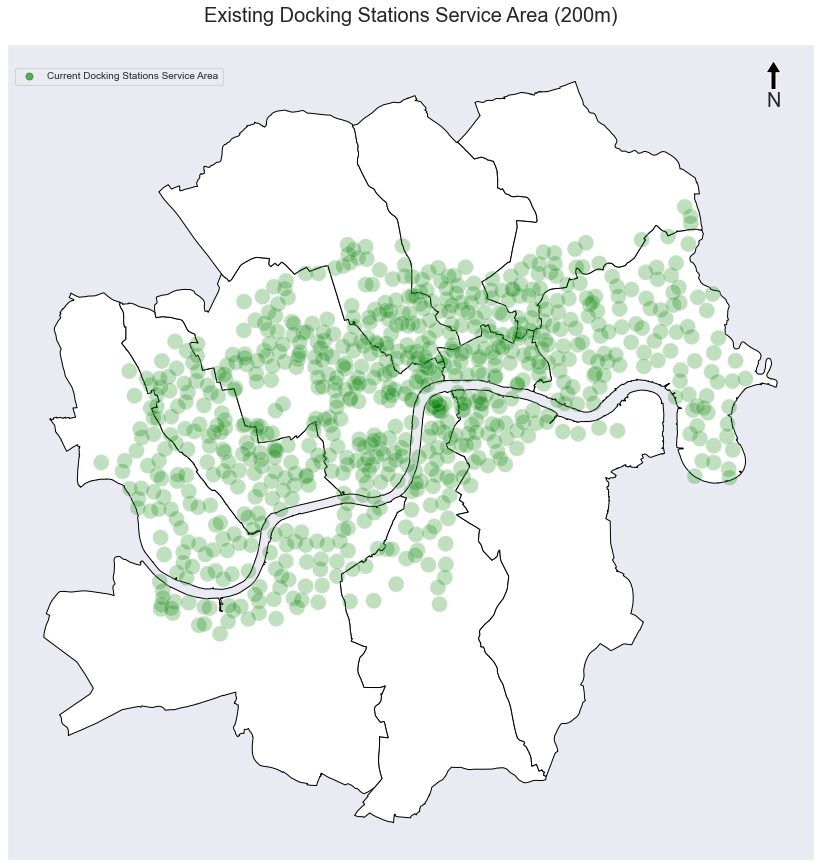

In [572]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')


#BEI_variables_ind.plot(ax=ax, column='BEI_ind', 
#                       legend=True, figsize=(8,8),scheme='user_defined', 
#                       classification_kwds={'bins':[one_std,one_std*2]}, 
#                       cmap="Reds",alpha=0.5);

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.6).set_title(
    "Existing Docking Stations Service Area (200m)", y=1.02, size=20
);
boros.plot(ax=ax,facecolor="white",edgecolor='black')


trip_7domain['buffer200'].plot(ax=ax,color="green", alpha=0.25)

green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Current Docking Stations Service Area')

plt.legend(handles=[green_dot],loc=[0.01,0.95], prop={'size': 10})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig("figures/map_4_dock_buffer", dpi=500)

### Dissolve all buffers

In [69]:
list_of_single_column = trip_7domain['buffer200'].tolist()

In [70]:
from shapely.geometry import shape
from shapely.ops import unary_union

union = unary_union([shape(s.__geo_interface__) for s in trip_7domain['buffer200']])

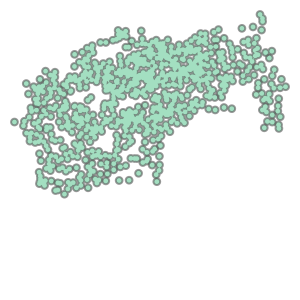

In [71]:
union

### Calculate the overlapped area for each LSOA with docking stations' service area

In [72]:
BEI_variables_ind['geometry']

0       POLYGON ((532105.092 182011.230, 532162.491 18...
1       POLYGON ((532746.813 181786.891, 532671.688 18...
2       POLYGON ((532135.145 182198.119, 532158.250 18...
3       POLYGON ((533807.946 180767.770, 533649.063 18...
4       POLYGON ((527317.841 184750.587, 527357.075 18...
                              ...                        
1412    POLYGON ((532726.570 183211.594, 532719.197 18...
1413    POLYGON ((535485.625 186863.250, 535487.798 18...
1414    POLYGON ((533056.000 182962.000, 533055.000 18...
1415    POLYGON ((534776.000 183995.000, 534809.638 18...
1416    POLYGON ((534918.108 185913.311, 534885.850 18...
Name: geometry, Length: 1417, dtype: geometry

In [73]:
BEI_variables_ind['overlap%'] = 0.00

In [74]:
BEI_variables_ind['geometry'][0].area

133320.76877877172

In [75]:
union.intersection(BEI_variables_ind['geometry'][0]).area

131926.25093653967

In [76]:
len(BEI_variables_ind)

1417

In [77]:
from shapely.geometry import box



# find intersection of rectangles (probably a more elegant way to do this)
for i in range(0,1417):
    #print(f'{i}')
    this_area = BEI_variables_ind['geometry'][i].area
    this_overlap = union.intersection(BEI_variables_ind['geometry'][i]).area
    this_overlap_per = (this_overlap/this_area)*100
    BEI_variables_ind['overlap%'][i] = this_overlap_per

    
#(g1.intersection(g8).area/g1.area)*100

In [78]:
BEI_variables_ind['overlap%']

0        98.954013
1        99.982234
2       100.000000
3        90.566260
4         0.000000
           ...    
1412     99.477860
1413      0.000000
1414     98.526659
1415     69.732035
1416      0.000000
Name: overlap%, Length: 1417, dtype: float64

In [79]:
BEI_variables_ind['overlap%'].max()

100.00000000000004

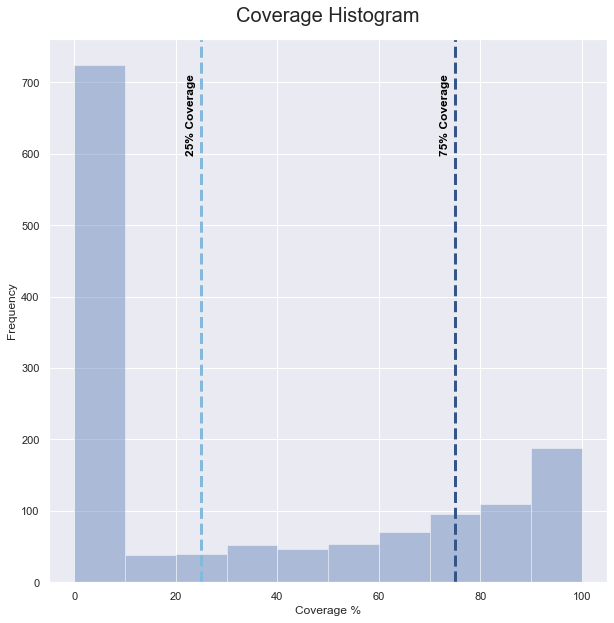

In [482]:
fig, ax = plt.subplots(figsize=(10, 10))



sns.distplot(BEI_variables_ind['overlap%'], bins = 10,color='b', kde=False).set_title(
    "Coverage Histogram", y=1.02, size=20
);

plt.xlabel('Coverage %')
plt.ylabel('Frequency')



plt.axvline(
    25, color="#83badb", linestyle="dashed", linewidth=3)

plt.axvline(
    75, color="#355586", linestyle="dashed", linewidth=3)

plt.text(22, 600, "25% Coverage", horizontalalignment='left', size='medium', color='black', weight='semibold',rotation=90)
plt.text(72, 600, "75% Coverage", horizontalalignment='left', size='medium', color='black', weight='semibold',rotation=90)


fig.savefig("figures/fig_4_cov_hist", dpi=500)

In [84]:
BEI_variables_ind['overlap%'][(BEI_variables_ind['overlap%'] <= 25)].count()

782

In [85]:
cov0_25 = BEI_variables_ind_boro[(BEI_variables_ind_boro['overlap%'] <= 25)]

In [86]:
cov25_75 = BEI_variables_ind_boro[(BEI_variables_ind_boro['overlap%'] > 25) & (BEI_variables_ind_boro['overlap%'] <= 75)]

In [87]:
cov75_100 = BEI_variables_ind_boro[(BEI_variables_ind_boro['overlap%'] > 75)]

In [89]:
cov0_25_name = cov0_25.groupby('Borough_na')

In [90]:
cov0_25_name.Borough_na.count()

Borough_na
Camden                     92
Hackney                   113
Hammersmith and Fulham     43
Islington                  98
Kensington and Chelsea     12
Lambeth                   124
Southwark                 127
Tower Hamlets              16
Wandsworth                126
Westminster                31
Name: Borough_na, dtype: int64

In [91]:
cov25_75_name = cov25_75.groupby('Borough_na')
cov25_75_name.Borough_na.count()

Borough_na
Camden                    16
Hackney                   16
Hammersmith and Fulham    43
Islington                  6
Kensington and Chelsea    37
Lambeth                   31
Southwark                 15
Tower Hamlets             71
Wandsworth                30
Westminster               26
Name: Borough_na, dtype: int64

In [92]:
cov75_100_name = cov75_100.groupby('Borough_na')
cov75_100_name.Borough_na.count()

Borough_na
Camden                    25
City of London             6
Hackney                   15
Hammersmith and Fulham    27
Islington                 19
Kensington and Chelsea    54
Lambeth                   23
Southwark                 24
Tower Hamlets             57
Wandsworth                23
Westminster               71
Name: Borough_na, dtype: int64

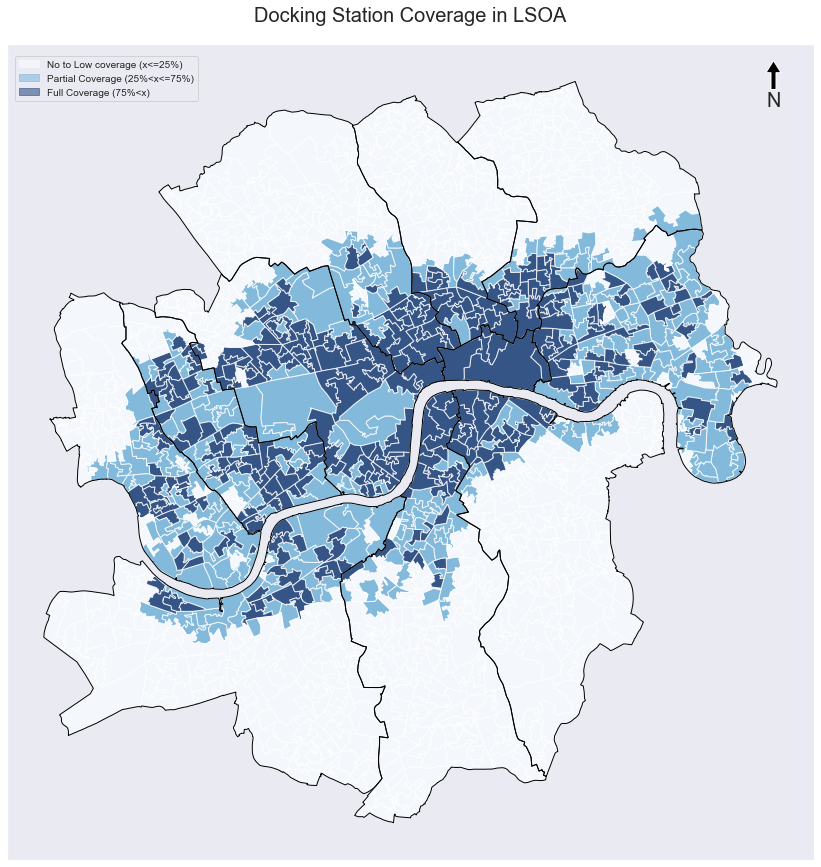

In [574]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')



BEI_variables_ind.plot(ax=ax, column='overlap%', legend=True, 
                       figsize=(8,8),scheme='user_defined', 
                       classification_kwds={'bins':[25,75]}, 
                       cmap="Blues", alpha=0.8).set_title(
    "Docking Station Coverage in LSOA", y=1.02, size=20
);


boros.plot(ax=ax,facecolor="None",edgecolor='black')


lv1_patch = mpatches.Patch(color='#fafcfe',alpha=0.6, label='No to Low coverage (x<=25%)')
lv2_patch = mpatches.Patch(color='#83badb',alpha=0.6, label='Partial Coverage (25%<x<=75%)')
lv3_patch = mpatches.Patch(color='#355586',alpha=0.6, label='Full Coverage (75%<x)')



plt.legend(handles=[lv1_patch,lv2_patch,lv3_patch],loc=[0.01,0.93], prop={'size': 10})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig("figures/map_5a_coverage", dpi=500)

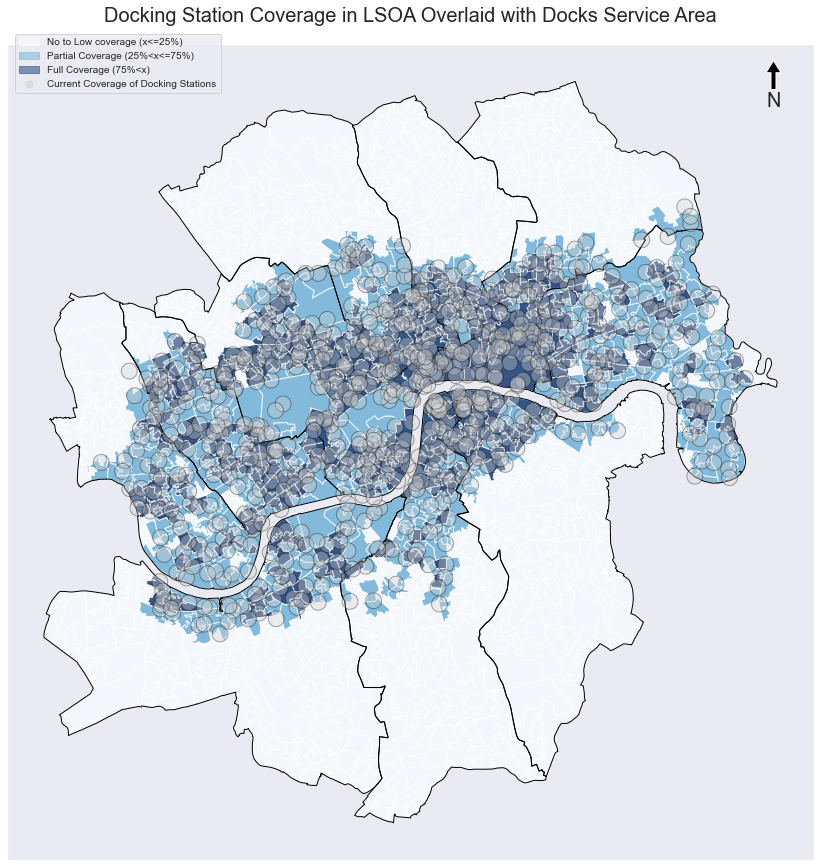

In [575]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')



BEI_variables_ind.plot(ax=ax, column='overlap%', legend=True, 
                       figsize=(8,8),scheme='user_defined', 
                       classification_kwds={'bins':[25,75]}, 
                       cmap="Blues", alpha=0.8).set_title(
    "Docking Station Coverage in LSOA Overlaid with Docks Service Area", y=1.02, size=20
);


boros.plot(ax=ax,facecolor="None",edgecolor='black')
trip_7domain['buffer200'].plot(ax=ax,facecolor="lightgrey", edgecolor="black", alpha=0.35)


lv1_patch = mpatches.Patch(color='#fafcfe',alpha=0.6, label='No to Low coverage (x<=25%)')
lv2_patch = mpatches.Patch(color='#83badb',alpha=0.6, label='Partial Coverage (25%<x<=75%)')
lv3_patch = mpatches.Patch(color='#355586',alpha=0.6, label='Full Coverage (75%<x)')
white_dot = mlines.Line2D([], [], color='lightgrey',markeredgecolor='lightgrey', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Current Coverage of Docking Stations')


plt.legend(handles=[lv1_patch,lv2_patch,lv3_patch,white_dot],loc=[0.01,0.94], prop={'size': 10})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig("figures/map_5b_coverage_withbuffer", dpi=500)

In [95]:
print(BEI_variables_ind.columns.tolist())

['LSOA11CD', 'LSOA11NM', 'Borough_na', 'geometry', 'Youth(<18)_norm', 'Elderly(>6_norm', 'No_car_hou_norm', 'Minority_p_norm', 'Unemployed_norm', 'z_score_youth', 'z_score_elderly', 'z_score_nocar', 'z_score_Minor', 'z_score_unemployed', 'z_score_youth_zero', 'z_score_elderly_zero', 'z_score_nocar_zero', 'z_score_Minor_zero', 'z_score_unemployed_zero', 'BEI_ind', 'BEI_ind_zs', 'overlap%']


In [96]:
BEI_dem_cov = BEI_variables_ind

In [97]:
to_drop = ['Youth(<18)_norm', 'Elderly(>6_norm', 'No_car_hou_norm', 'Minority_p_norm', 'Unemployed_norm', 'z_score_youth',
           'z_score_elderly', 'z_score_nocar', 'z_score_Minor', 'z_score_unemployed',
          'z_score_youth_zero', 'z_score_elderly_zero', 'z_score_nocar_zero', 'z_score_Minor_zero', 'z_score_unemployed_zero', 'BEI_ind_zs']
#'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'
BEI_dem_cov = BEI_dem_cov.drop(columns=to_drop)
BEI_dem_cov.head(2)

LSOA11CD             LSOA11NM      Borough_na  \
0  E01000001  City of London 001A  City of London   
1  E01000002  City of London 001B  City of London   

                                            geometry   BEI_ind   overlap%  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  0.950788  98.954013  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  0.000000  99.982234

In [98]:
BEI_dem_cov['uncovered%'] = 100 - BEI_dem_cov['overlap%']

In [99]:
BEI_dem_cov['uncovered%'].min()

-4.263256414560601e-14

In [100]:
BEI_dem_cov['uncovered%'][BEI_dem_cov['uncovered%'] < 0] = 0

In [101]:
BEI_dem_cov['uncovered%'].min()

0.0

In [102]:
BEI_dem_cov.head(2)

LSOA11CD             LSOA11NM      Borough_na  \
0  E01000001  City of London 001A  City of London   
1  E01000002  City of London 001B  City of London   

                                            geometry   BEI_ind   overlap%  \
0  POLYGON ((532105.092 182011.230, 532162.491 18...  0.950788  98.954013   
1  POLYGON ((532746.813 181786.891, 532671.688 18...  0.000000  99.982234   

   uncovered%  
0    1.045987  
1    0.017766

In [103]:
BEI_dem_cov.loc[BEI_dem_cov['LSOA11CD'] == 'E01004723']

LSOA11CD          LSOA11NM   Borough_na  \
1281  E01004723  Westminster 005F  Westminster   

                                               geometry  BEI_ind  overlap%  \
1281  POLYGON ((524761.839 182998.001, 524838.620 18...  5.32308       0.0   

      uncovered%  
1281       100.0

### Categorize LSOA based on both docking station coverage and BEI

In general, three types of conditions can be found in bike sharing in London, which are Undersupply, Oversupply and Balanced.
* Undersupply: High demand (high BEI score), low supply (low docking station coverage)
* Oversupply: Low demand (low BEI score), high supply (high docking station coverage)
* Balanced: Demand and supply are similar (e.g., high BEI but also high coverage; very low BEI but also no coverage)

In [104]:
BEI_cat = BEI_dem_cov

In [105]:
BEI_cat['var1'] = ""
BEI_cat['var2'] = ""

In [106]:
for row in range(0,1417):
    if BEI_cat['BEI_ind'][row] >= one_std*2:
        BEI_cat['var1'][row] = 3
    elif BEI_cat['BEI_ind'][row] < one_std*2 and BEI_cat['BEI_ind'][row] >= one_std*1:
        BEI_cat['var1'][row] = 2
    elif BEI_cat['BEI_ind'][row] < one_std:
        BEI_cat['var1'][row] = 1

In [107]:
for row in range(0,1417):
    if BEI_cat['overlap%'][row] >= 75:
        BEI_cat['var2'][row] = 'C'
    elif BEI_cat['overlap%'][row] < 75 and BEI_cat['overlap%'][row] >= 25:
        BEI_cat['var2'][row] = 'B'
    elif BEI_cat['overlap%'][row] < 25:
        BEI_cat['var2'][row] = 'A'

In [108]:
BEI_cat["bi_var"] = BEI_cat["var1"].astype(str) + BEI_cat["var2"]

In [109]:
BEI_cat.to_file('BEI_dem_cov.shp')

In [110]:
biv_Palette = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#a08fa1', '2C': '#646d93',
               '3A': '#d67c7c', '3B': '#9b6471', '3C': '#614d67'}


biv_Palette

{'1A': '#e2e2e2',
 '1B': '#a4b7ce',
 '1C': '#678bbb',
 '2A': '#dcb1b1',
 '2B': '#a08fa1',
 '2C': '#646d93',
 '3A': '#d67c7c',
 '3B': '#9b6471',
 '3C': '#614d67'}

In [111]:
import os
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
import geopandas as gpd

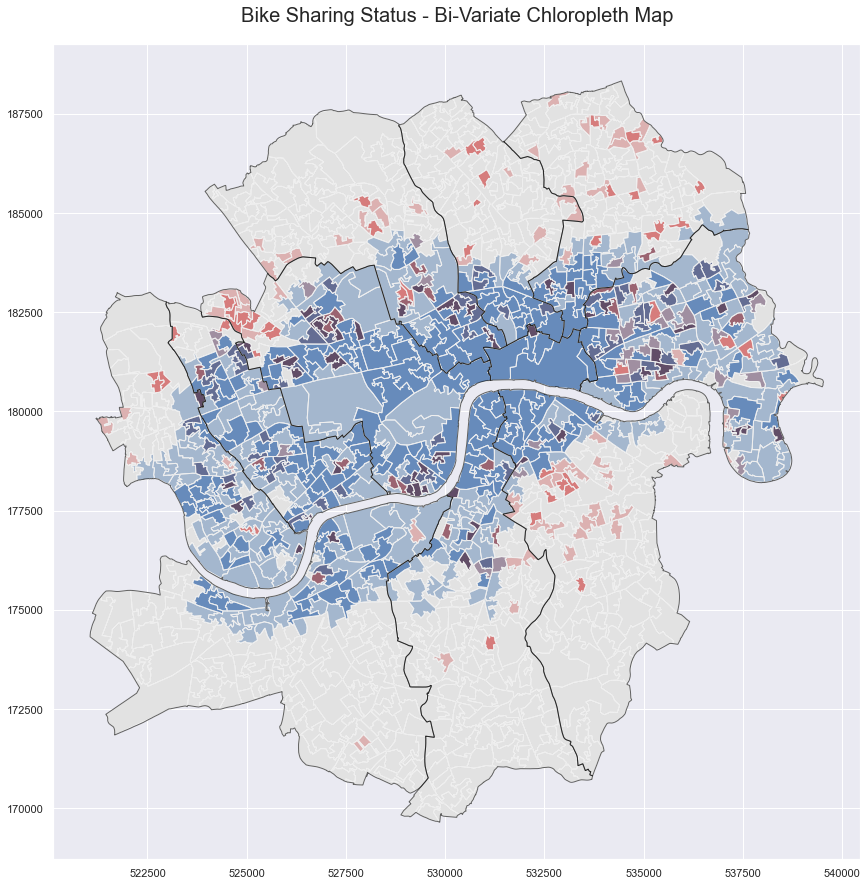

In [112]:
# Plot data
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Bike Sharing Status - Bi-Variate Chloropleth Map", y=1.02, size=20
);

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

    
    
BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.2)
boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)


#ax.set_axis_off()
plt.show()

In [113]:
biv_Palette2 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}


#Only undersupply
biv_Palette3 = {'1A': '#e2e2e2', '1B': '#e2e2e2', '1C': '#e2e2e2',
               '2A': '#dcb1b1', '2B': '#e2e2e2', '2C': '#e2e2e2',
               '3A': '#d67c7c', '3B': '#dcb1b1', '3C': '#e2e2e2'}

#Only oversupply
biv_Palette4 = {'1A': '#e2e2e2', '1B': '#a4b7ce', '1C': '#678bbb',
               '2A': '#e2e2e2', '2B': '#e2e2e2', '2C': '#a4b7ce',
               '3A': '#e2e2e2', '3B': '#e2e2e2', '3C': '#e2e2e2'}

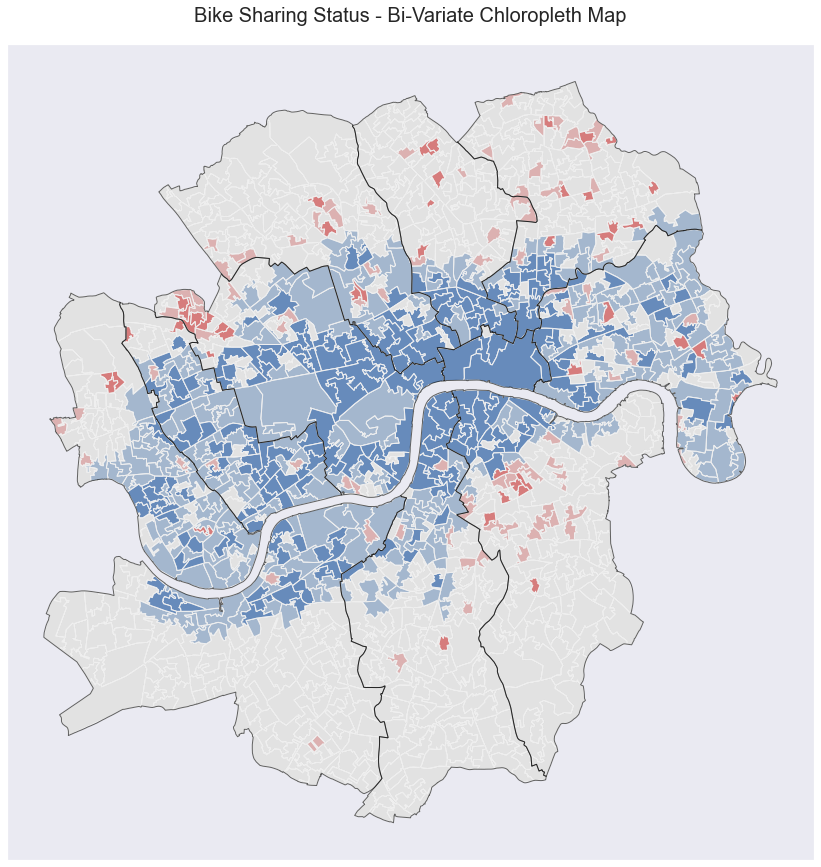

In [114]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Bike Sharing Status - Bi-Variate Chloropleth Map", y=1.02, size=20
);

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.2)
boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [115]:
BEI_final_count = BEI_cat.groupby(['bi_var'])

In [116]:
BEI_final_count.bi_var.count()

bi_var
1A    669
1B    243
1C    229
2A     67
2B     28
2C     62
3A     46
3B     20
3C     53
Name: bi_var, dtype: int64

In [117]:
BEI_final_hist = BEI_cat

In [119]:
BEI_final_hist.loc[BEI_final_hist.bi_var == '2C', 'bi_var'] = "1B"
BEI_final_hist.loc[BEI_final_hist.bi_var == '3B', 'bi_var'] = "2A"
BEI_final_hist.loc[BEI_final_hist.bi_var == '3C', 'bi_var'] = "1A"
BEI_final_hist.loc[BEI_final_hist.bi_var == '2B', 'bi_var'] = "1A"


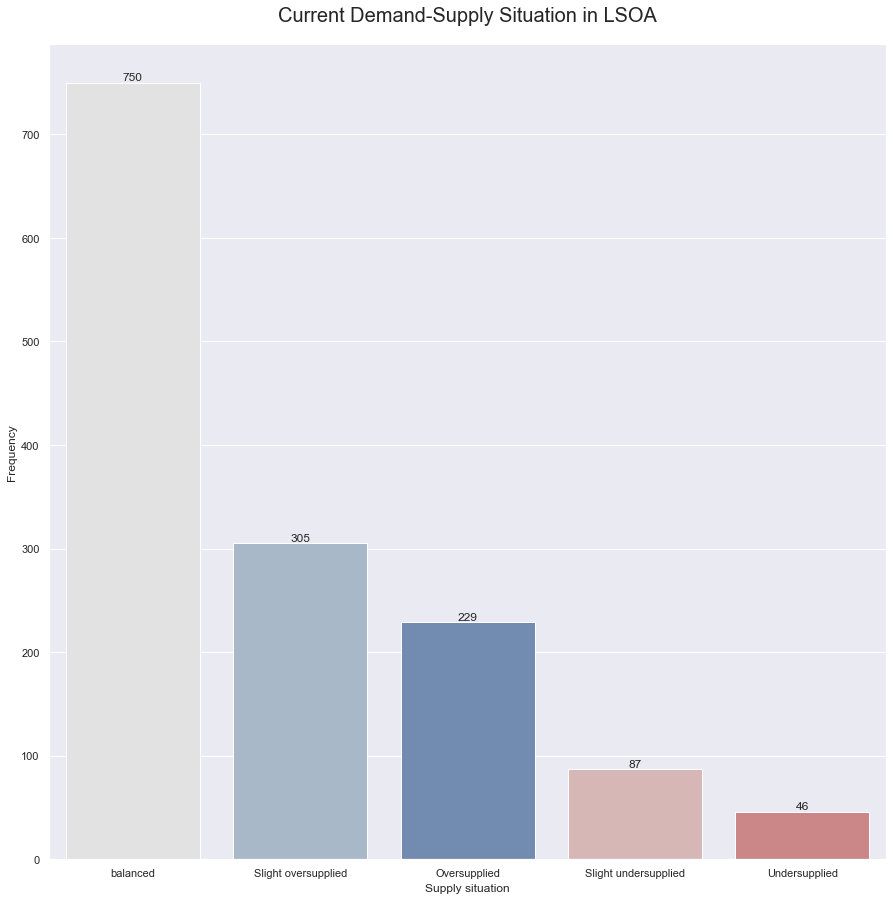

In [501]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.countplot(x="bi_var", data=BEI_final_hist, 
                order=BEI_final_hist['bi_var'].value_counts().index,
                palette=biv_Palette2)

ax.set_title(
    "Current Demand-Supply Situation in LSOA", y=1.02, size=20
);



ax.bar_label(ax.containers[0])

plt.xlabel('Supply situation')
plt.xticks([0, 1, 2, 3, 4],['balanced', 'Slight oversupplied', 'Oversupplied','Slight undersupplied','Undersupplied'])

plt.ylabel('Frequency')



fig.savefig("figures/fig_5_supply_bar", dpi=500)

In [381]:
boro_cat = pd.DataFrame(columns=['boro','under','slight_under', 'balanced','slight_over','over','sum'],index=range(1,12))

In [382]:
boro_list = ["Camden", "City of London", "Hackney", "Hammersmith and Fulham","Islington","Kensington and Chelsea","Lambeth","Southwark","Tower Hamlets","Wandsworth","Westminster"]
count = 1

for i in boro_list:
    print(f"Now {i}")
    boro_sum = BEI_final_hist.loc[BEI_final_hist['Borough_na'] == i]
    boro_cat["boro"][count] = i
    print(len(boro_sum.loc[boro_sum['bi_var'] == "3A"]))
    boro_cat["under"][count] = len(boro_sum.loc[boro_sum['bi_var'] == "3A"])
    
    boro_cat["slight_under"][count] = len(boro_sum.loc[boro_sum['bi_var'] == "2A"]) + len(boro_sum.loc[boro_sum['bi_var'] == "3B"])
    
    boro_cat["balanced"][count] = len(boro_sum.loc[boro_sum['bi_var'] == "1A"]) + len(boro_sum.loc[boro_sum['bi_var'] == "2B"]) + len(boro_sum.loc[boro_sum['bi_var'] == "3C"])
    
    boro_cat["slight_over"][count] = len(boro_sum.loc[boro_sum['bi_var'] == "1B"]) + len(boro_sum.loc[boro_sum['bi_var'] == "2C"])
    
    boro_cat["over"][count] = len(boro_sum.loc[boro_sum['bi_var'] == "1C"])

    boro_cat["sum"][count] = boro_cat["under"][count] + boro_cat["slight_under"][count] + boro_cat["balanced"][count] + boro_cat["slight_over"][count] + boro_cat["over"][count]

    count = count + 1

Now Camden
4
Now City of London
0
Now Hackney
10
Now Hammersmith and Fulham
4
Now Islington
5
Now Kensington and Chelsea
2
Now Lambeth
1
Now Southwark
7
Now Tower Hamlets
5
Now Wandsworth
0
Now Westminster
8


In [384]:
boro_cat

boro under slight_under balanced slight_over over  sum
1                   Camden     4           12       88          15   14  133
2           City of London     0            0        1           0    5    6
3                  Hackney    10           14       93          14   13  144
4   Hammersmith and Fulham     4            4       39          49   17  113
5                Islington     5            7       86          10   15  123
6   Kensington and Chelsea     2            3       16          44   38  103
7                  Lambeth     1            7      124          28   18  178
8                Southwark     7           19      105          15   20  166
9            Tower Hamlets     5            8       36          68   27  144
10              Wandsworth     0            3      125          30   21  179
11             Westminster     8           10       37          32   41  128

In [388]:
boro_cat_per = pd.DataFrame(columns=['boro','under_per','slight_under_per', 'balanced_per','slight_over_per','over_per'],index=range(1,12))

In [399]:
count = 1

for i in boro_list:
    print(f"Now {i}")
    boro_sum = boro_cat.loc[boro_cat['boro'] == i]
    boro_cat_per["boro"][count] = i
    
    boro_cat_per["under_per"][count] = (boro_sum['under'].sum() / boro_sum['sum'].sum())
    boro_cat_per["slight_under_per"][count] = (boro_sum['slight_under'].sum() / boro_sum['sum'].sum())
    boro_cat_per["balanced_per"][count] = (boro_sum['balanced'].sum() / boro_sum['sum'].sum())
    boro_cat_per["slight_over_per"][count] = (boro_sum['slight_over'].sum() / boro_sum['sum'].sum())
    boro_cat_per["over_per"][count] = (boro_sum['over'].sum() / boro_sum['sum'].sum())

    
    
    count = count + 1

Now Camden
Now City of London
Now Hackney
Now Hammersmith and Fulham
Now Islington
Now Kensington and Chelsea
Now Lambeth
Now Southwark
Now Tower Hamlets
Now Wandsworth
Now Westminster


In [400]:
boro_cat_per

boro under_per slight_under_per balanced_per  \
1                   Camden  0.030075         0.090226     0.661654   
2           City of London       0.0              0.0     0.166667   
3                  Hackney  0.069444         0.097222     0.645833   
4   Hammersmith and Fulham  0.035398         0.035398     0.345133   
5                Islington   0.04065         0.056911     0.699187   
6   Kensington and Chelsea  0.019417         0.029126      0.15534   
7                  Lambeth  0.005618         0.039326     0.696629   
8                Southwark  0.042169         0.114458      0.63253   
9            Tower Hamlets  0.034722         0.055556         0.25   
10              Wandsworth       0.0          0.01676     0.698324   
11             Westminster    0.0625         0.078125     0.289062   

   slight_over_per  over_per  
1         0.112782  0.105263  
2              0.0  0.833333  
3         0.097222  0.090278  
4         0.433628  0.150442  
5         0.081301  0.121951  
6         0.427184  0.368932  
7         0.157303  0.101124  
8         0.090361  0.120482  
9         0.472222    0.1875  
10        0.167598  0.117318  
11            0.25  0.320312

In [438]:
boro_cat = boro_cat.drop(columns='sum')

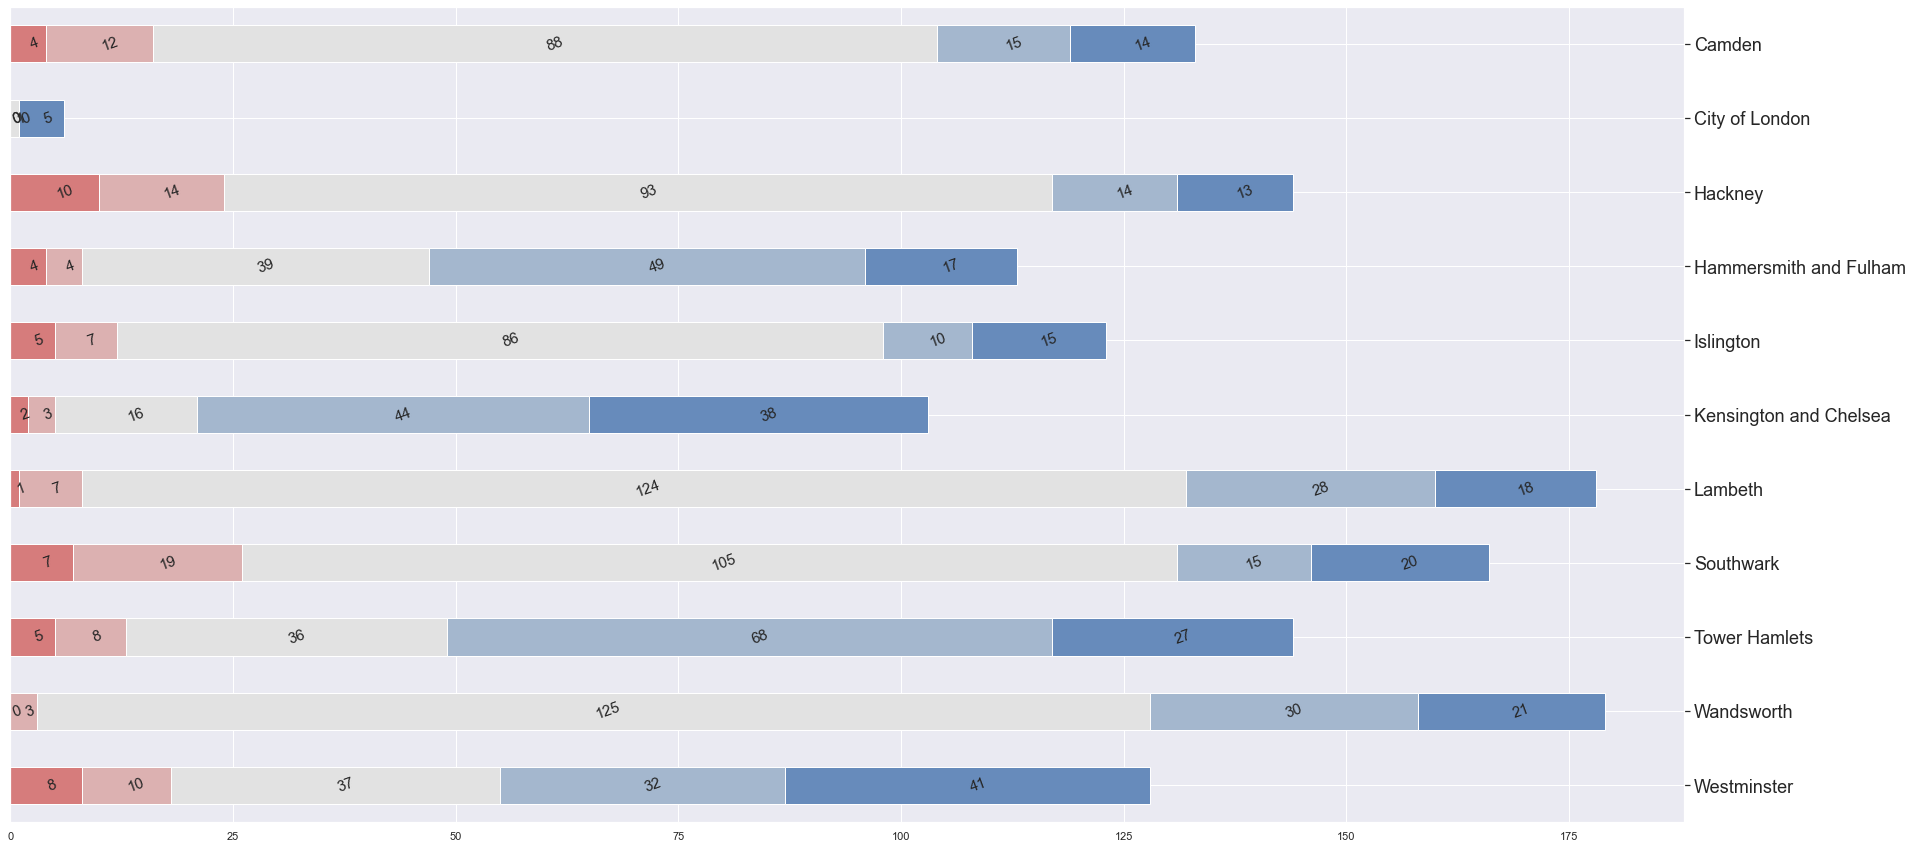

In [502]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(30, 15))

boro_cat.plot(ax=ax,
    x = 'boro',
    kind = 'barh',
    stacked = True,
    mark_right = True, 
    legend=False,
    color=['#d67c7c', '#dcb1b1', '#e2e2e2','#a4b7ce','#678bbb'])
ax.invert_yaxis()
ax.yaxis.set_ticks_position('right')
plt.ylabel(None)
ax.yaxis.set_tick_params(labelsize=18)


df_total = boro_cat["under"] + boro_cat["slight_under"] + boro_cat["balanced"]+ boro_cat["slight_over"]+ boro_cat["over"]
df_rel = boro_cat[boro_cat.columns[1:]]

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(boro_cat.iloc[:, 1:].cumsum(1)[n], 
                                         boro_cat[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)), 
                 va = 'center', ha = 'left', rotation = 20, fontsize = 15)
        
fig.savefig("figures/fig_6a_demand_boro_abs", dpi=500)

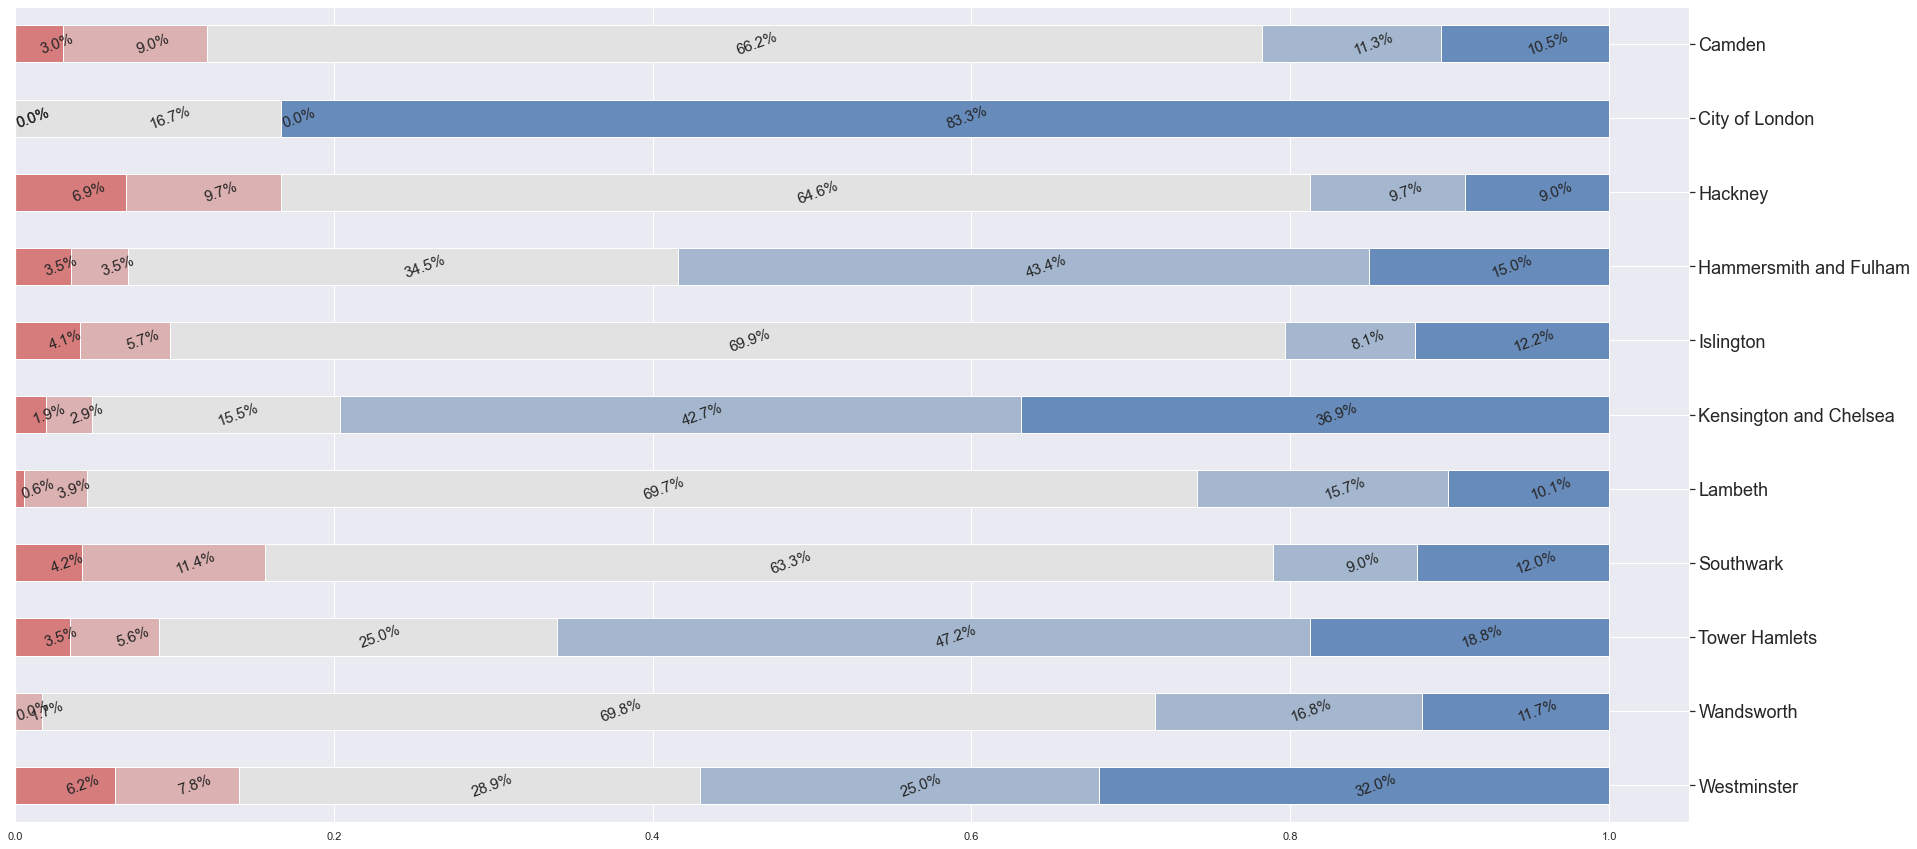

In [503]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(30, 15))

boro_cat_per.plot(ax=ax,
    x = 'boro',
    kind = 'barh',
    stacked = True,
    mark_right = True, 
    legend=False,
    color=['#d67c7c', '#dcb1b1', '#e2e2e2','#a4b7ce','#678bbb'])
ax.invert_yaxis()
ax.yaxis.set_ticks_position('right')
plt.ylabel(None)
ax.yaxis.set_tick_params(labelsize=18)


df_total = boro_cat_per["under_per"] + boro_cat_per["slight_under_per"] + boro_cat_per["balanced_per"]+ boro_cat_per["slight_over_per"]+ boro_cat_per["over_per"]
df_rel = boro_cat_per[boro_cat_per.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(boro_cat_per.iloc[:, 1:].cumsum(1)[n], 
                                         boro_cat_per[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'left', rotation = 20, fontsize = 15)
        
fig.savefig("figures/fig_6b_demand_boro_per", dpi=500)

#### Bi-variate Legend

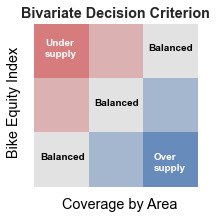

In [525]:
import matplotlib
import matplotlib.pyplot as plt

colors = '#e2e2e2 #dcb1b1 #d67c7c #a4b7ce #678bbb'.split()
cmap = matplotlib.colors.ListedColormap(colors, name='colors', N=None)

m = [
    [2, 1, 0],
    [1, 0, 3],
    [0, 3, 4],
]
fig, ax = plt.subplots(figsize=(3,3))

plt.imshow(m, cmap=cmap)
fig.patch.set_facecolor('None')

plt.title('Bivariate Decision Criterion', size='large', fontweight ="bold")

ax.axis('off')


plt.text(0 , 2.9, "Coverage by Area", horizontalalignment='left', size='large', color='black')
plt.text(-1 , 1.9, "Bike Equity Index", horizontalalignment='left', size='large', color='black',rotation=90)

plt.text(-0.3 , -0.1, "Under", horizontalalignment='left', size='small', color='white', fontweight ="bold")
plt.text(-0.3 , 0.1, "supply", horizontalalignment='left', size='small', color='white', fontweight ="bold")


plt.text(1.7, 2, "Over", horizontalalignment='left', size='small', color='white', fontweight ="bold")
plt.text(1.7, 2.2, "supply", horizontalalignment='left', size='small', color='white', fontweight ="bold")

plt.text(-0.4, 2, "Balanced", horizontalalignment='left', size='small', color='black', fontweight ="semibold")
plt.text(1.6, 0, "Balanced", horizontalalignment='left', size='small', color='black', fontweight ="semibold")
plt.text(0.6, 1, "Balanced", horizontalalignment='left', size='small', color='black', fontweight ="semibold")


plt.show()
fig.savefig("figures/fig_2_Bivaraite_Legend", dpi=500)

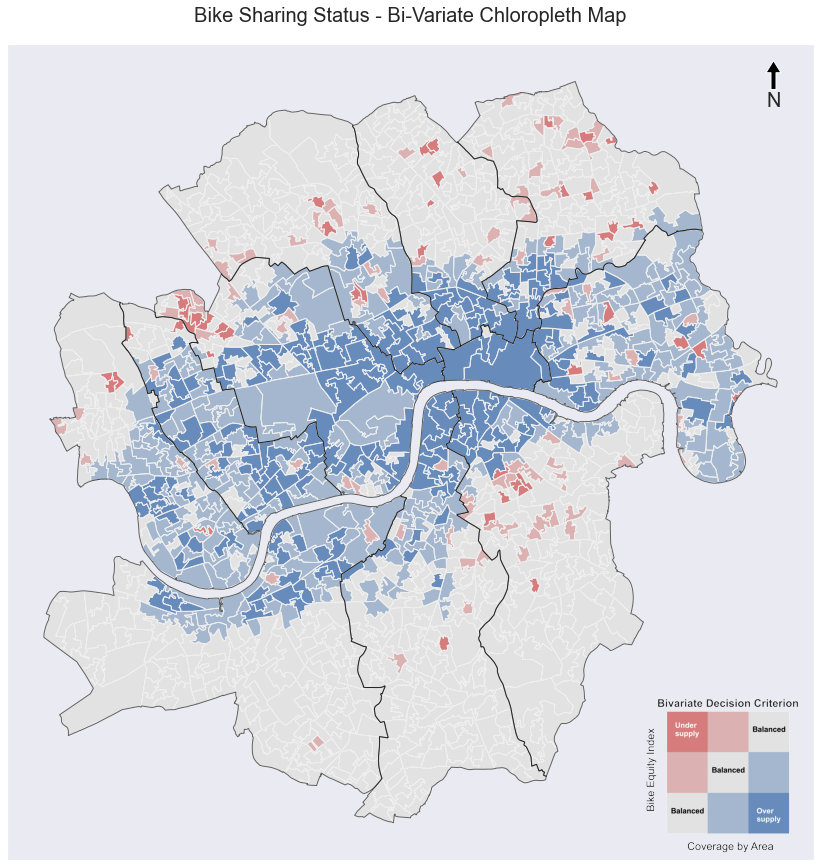

In [576]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Bike Sharing Status - Bi-Variate Chloropleth Map", y=1.02, size=20
);

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette2[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.2)
boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


im = plt.imread('figures/fig_2_Bivaraite_Legend.png')

newax = fig.add_axes([0.73,0.13,0.15,0.15], anchor='SE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.show()


fig.savefig("figures/map_6_demand_supply_final_map", dpi=500)

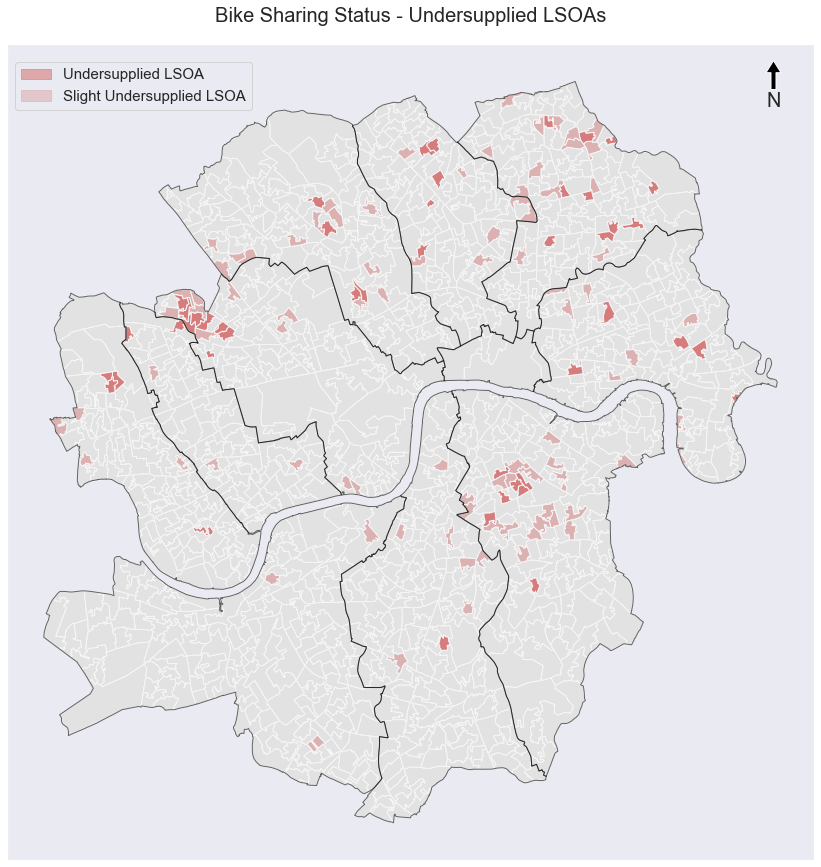

In [577]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Bike Sharing Status - Undersupplied LSOAs", y=1.02, size=20
);

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette3[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.1)
boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)

under_patch = mpatches.Patch(color='#d67c7c',alpha=0.6, label='Undersupplied LSOA')
sli_under_patch = mpatches.Patch(color='#dcb1b1',alpha=0.6, label='Slight Undersupplied LSOA')



plt.legend(handles=[under_patch, sli_under_patch],loc=[0.01,0.92], prop={'size': 15})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)



plt.show()

fig.savefig("figures/map_6b_undersupplied_map", dpi=500)

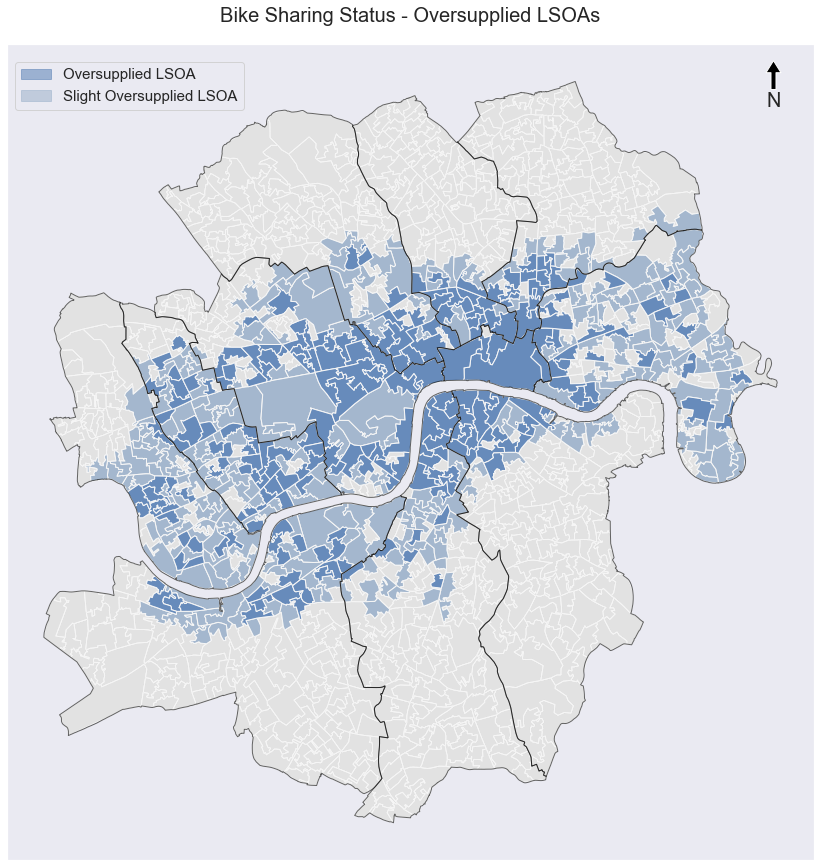

In [578]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Bike Sharing Status - Oversupplied LSOAs", y=1.02, size=20
);

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in BEI_dem_cov.groupby('bi_var'):
    
    # Define the color for each group using the dictionary
    color = biv_Palette4[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype)

BEI_variables_cleaned.plot(ax=ax, facecolor="None", edgecolor="lightgrey", alpha=0.1)
boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)

over_patch = mpatches.Patch(color='#678bbb',alpha=0.6, label='Oversupplied LSOA')
sli_over_patch = mpatches.Patch(color='#a4b7ce',alpha=0.6, label='Slight Oversupplied LSOA')



plt.legend(handles=[over_patch, sli_over_patch],loc=[0.01,0.92], prop={'size': 15})

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.show()

fig.savefig("figures/map_6c_oversupplied_map", dpi=500)

## Potential Locations for Future Docking Stations

In [199]:
London_Rd = gpd.read_file('Inner_road.shp')



In [200]:
print(London_Rd.shape)

(119672, 11)


In [201]:
London_Rd.drop(London_Rd[London_Rd['fclass'] == "motorway"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "motorway_link"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "path"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "primary_link"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "secondary_link"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "steps"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "tertiary_link"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track_grade1"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track_grade2"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track_grade3"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track_grade4"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "track_grade5"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "trunk_link"].index, inplace = True)
London_Rd.drop(London_Rd[London_Rd['fclass'] == "unknown"].index, inplace = True)




In [202]:
London_Rd.sample(20)

osm_id  code       fclass                  name    ref oneway  \
91056    107278860  5141      service                  None   None      B   
29824    288244784  5112        trunk   Peckham High Street   A202      F   
9620     261080783  5122  residential        Bristowe Close   None      B   
79758    100999065  5122  residential   Holly Lodge Gardens   None      B   
45418    899253398  5153      footway                  None   None      B   
24282   1022711165  5153      footway                  None   None      B   
49382      4422806  5153      footway                  None   None      B   
44200    838518197  5122  residential                  None   None      B   
23089    997564738  5113      primary     Albert Embankment  A3036      F   
82375    473654340  5141      service                  None   None      B   
35326      4315083  5122  residential         Gonston Close   None      B   
15440    682488188  5112        trunk          Brixton Road    A23      F   
10396    337193571  5141      service                  None   None      B   
98819    725383114  5141      service                  None   None      B   
46229    933864117  5141      service                  None   None      B   
49144   1059944165  5153      footway                  None   None      B   
100882   923967970  5124   pedestrian                  None   None      B   
7095     120750851  5141      service       Cleveland Place   None      B   
108888   637043146  5112        trunk          Curtain Road  A1202      F   
66468      4259311  5122  residential  New Burlington Place   None      B   

        maxspeed  layer bridge tunnel  \
91056          0      0      F      F   
29824         32      0      F      F   
9620          32      0      F      F   
79758         32      0      F      F   
45418          0      0      F      F   
24282          0      0      F      F   
49382          0      0      F      F   
44200          0      0      F      F   
23089         32      0      F      F   
82375          0      0      F      F   
35326         32      0      F      F   
15440         48      0      F      F   
10396          0      0      F      F   
98819          0      0      F      F   
46229          0      0      F      F   
49144          0      0      F      F   
100882         0      0      F      F   
7095           0      0      F      F   
108888        32      0      F      F   
66468         32      0      F      F   

                                                 geometry  
91056   LINESTRING (-0.07450 51.51214, -0.07451 51.512...  
29824   LINESTRING (-0.06391 51.47406, -0.06382 51.47406)  
9620    LINESTRING (-0.11192 51.45058, -0.11209 51.450...  
79758   LINESTRING (-0.15329 51.56716, -0.15231 51.567...  
45418   LINESTRING (-0.21707 51.43859, -0.21710 51.438...  
24282   LINESTRING (-0.10106 51.46398, -0.10110 51.463...  
49382   LINESTRING (-0.17988 51.48821, -0.17991 51.48820)  
44200   LINESTRING (-0.17141 51.43980, -0.17152 51.43991)  
23089   LINESTRING (-0.12322 51.48727, -0.12325 51.487...  
82375   LINESTRING (-0.17902 51.54326, -0.17870 51.54320)  
35326   LINESTRING (-0.21671 51.43864, -0.21578 51.43866)  
15440   LINESTRING (-0.11082 51.48095, -0.11083 51.480...  
10396   LINESTRING (-0.10375 51.45414, -0.10383 51.454...  
98819   LINESTRING (-0.05264 51.52053, -0.05258 51.520...  
46229   LINESTRING (-0.21170 51.44984, -0.21118 51.44989)  
49144   LINESTRING (-0.18078 51.46507, -0.18073 51.465...  
100882  LINESTRING (-0.02480 51.53981, -0.02508 51.54005)  
7095    LINESTRING (-0.13670 51.50644, -0.13647 51.50619)  
108888  LINESTRING (-0.08028 51.52445, -0.08028 51.524...  
66468   LINESTRING (-0.14044 51.51244, -0.14106 51.512...

In [203]:
print(London_Rd.shape)

(111961, 11)


In [204]:
London_Rd_clean = London_Rd

<AxesSubplot:>

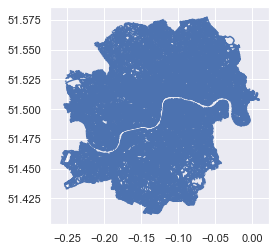

In [205]:
London_Rd_clean.plot()

In [206]:
London_Rd_clean = London_Rd_clean.to_crs("epsg:27700")

In [207]:
docks = gpd.read_file('current_docks.shp')


In [208]:
pip install -U geopandas

Note: you may need to restart the kernel to use updated packages.


In [209]:
import geopandas as gpd


In [210]:
nearest = gpd.sjoin_nearest(docks, London_Rd_clean, distance_col="dist")

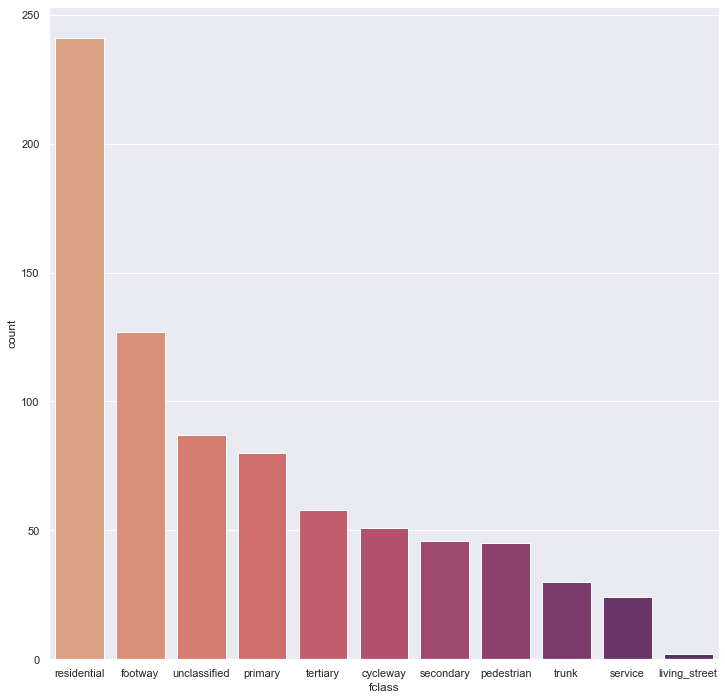

In [211]:
plt.figure(figsize=(12,12))
ax = sns.countplot(x="fclass", data=nearest, 
                order=["residential", "footway",'unclassified','primary','tertiary','cycleway','secondary','pedestrian','trunk','service','living_street'],
                 palette="flare")

(521690.43728349375, 539544.7760199225, 173865.7982902157, 185794.26336433933)

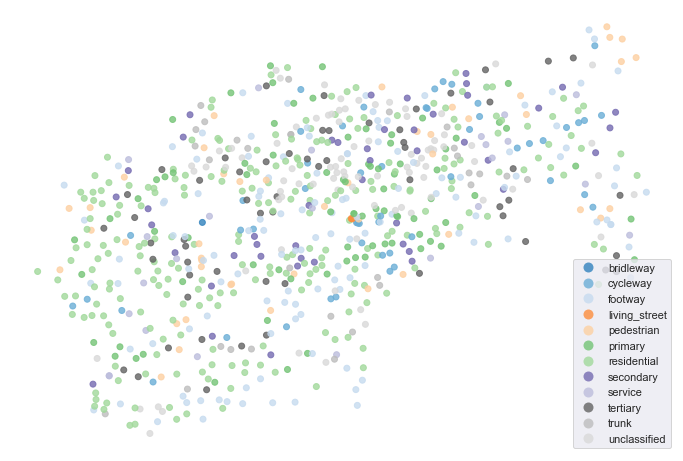

In [212]:
f, ax = plt.subplots(figsize=(12, 12))


nearest.plot(ax=ax, column='fclass', 
                       legend=True, figsize=(8,8), 
                       cmap="tab20c",alpha=0.8);

ax.axis("off")



In [213]:
London_Rd_potential_loc = London_Rd

remove "trunk" because the regulation doesnt allow

In [214]:
London_Rd_potential_loc.drop(London_Rd_potential_loc[London_Rd_potential_loc['fclass'] == "trunk"].index, inplace = True)


In [215]:
print(London_Rd_potential_loc['fclass'].unique())


['primary' 'tertiary' 'pedestrian' 'residential' 'secondary'
 'unclassified' 'footway' 'cycleway' 'service' 'living_street' 'bridleway']


In [216]:
London_Rd_potential_loc.to_crs("epsg:27700")

osm_id  code       fclass                 name   ref oneway  \
1          1530592  5113      primary  Borough High Street    A3      F   
2          2198814  5115     tertiary                 None  None      F   
3          2263970  5124   pedestrian     Trafalgar Square  None      B   
4          2263971  5113      primary       Pall Mall East    A4      F   
5          2263973  5122  residential    St James's Square  None      F   
...            ...   ...          ...                  ...   ...    ...   
119667  1068003938  5122  residential         Angel Street  None      F   
119668  1068003939  5153      footway                 None  None      B   
119669  1068003940  5153      footway                 None  None      B   
119670  1068003941  5153      footway                 None  None      B   
119671  1068004872  5153      footway                 None  None      B   

        maxspeed  layer bridge tunnel  \
1             48      0      F      F   
2             32      0      F      F   
3              0      0      F      F   
4             32      0      F      F   
5             32      0      F      F   
...          ...    ...    ...    ...   
119667        32      0      F      F   
119668         0      0      F      F   
119669         0      0      F      F   
119670         0      0      F      F   
119671         0      0      F      F   

                                                 geometry  
1       LINESTRING (532769.018 180313.710, 532769.123 ...  
2       LINESTRING (530059.813 180490.404, 530059.458 ...  
3       LINESTRING (529937.023 180473.678, 529939.868 ...  
4       LINESTRING (529806.320 180413.867, 529835.507 ...  
5       LINESTRING (529490.270 180261.307, 529458.276 ...  
...                                                   ...  
119667  LINESTRING (532125.405 181389.501, 532127.133 ...  
119668  LINESTRING (532032.902 181405.668, 532035.943 ...  
119669  LINESTRING (532029.586 181405.860, 532032.902 ...  
119670  LINESTRING (532127.821 181402.038, 532135.106 ...  
119671  LINESTRING (532140.388 181504.482, 532144.122 ...  

[108340 rows x 11 columns]

In [217]:
London_Rd_potential_loc.to_file('London_Rd_potential_loc.shp', driver='ESRI Shapefile')


Use Conrow et al., method to propose potential locations

1. export SHP to QGIS -> reproject -> dissolve -> QChainage (create potential location every 200m apart in Inner London)


2. Qchainage layer clip with existing_dock's 200m buffer -> get the potential locations for new facilities

3. Create a 15 meter buffer for these points (with dissolved result box ticked) -> get a dissolved buffer layer -> convert back to centroid (centroid for each part)
The purpose is to remove identifed potential being too close to one another.

4. Lastly, remove points within oversupplied lsoas

Total number of potential new locations identified: </br>
26574 (QChainage) -> 17140 (covered location removal) -> 13821 (close points merge) -> 11097 (oversupply removeal)

In [218]:
pot_docks = gpd.read_file('potential_dock_aug3.shp')

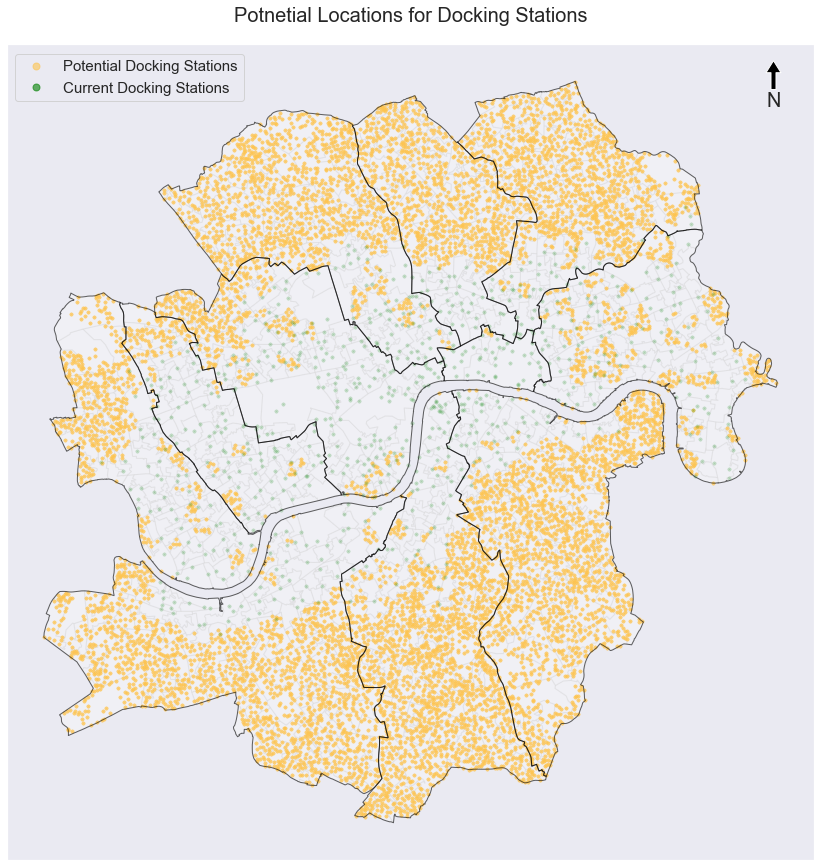

In [579]:
#### sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
ax.set_title(
    "Potnetial Locations for Docking Stations", y=1.02, size=20
);


BEI_variables_cleaned.plot(ax=ax, facecolor="white", edgecolor="lightgrey", alpha=0.3)
pot_docks.plot(ax=ax,marker="*", color="#fec44f", linewidth=2.7, markersize=2, alpha=0.75)
trip_7domain.plot(ax=ax, marker="*", color="green",linewidth=2.7, markersize=2, alpha=0.2)

boros.plot(ax=ax,facecolor="None",edgecolor='black', alpha = 0.6)

pot_dot = mlines.Line2D([], [], color='#fec44f', marker='o', linestyle='None',alpha=0.6,
                          markersize=7, label='Potential Docking Stations')



plt.legend(handles=[pot_dot,green_dot],loc=[0.01,0.93], prop={'size': 15})


ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


x, y, arrow_length = 0.95, 0.98, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)



plt.show()


fig.savefig("figures/map_7_pot_dock_map", dpi=500)